# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import joblib
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from time import time
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
% matplotlib inline

# II. Load Data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# III. Data Cleaning and Data Processing

In [3]:
def plot_value_distribution(df, nrows, ncols, ignore_cols):
    """
    Plots the value distribution of columns in a DataFrame.

    Args:
        df (DataFrame): The DataFrame containing the data to be plotted.
        nrows (int): The number of rows in the subplot grid.
        ncols (int): The number of columns in the subplot grid.
        ignore_cols (list): A list of column names to be ignored in the plot.

    Returns:
        None

    Raises:
        None

    """
    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))

    column_to_include = [col for col in df if col not in ignore_cols]
    df = df[column_to_include]
    
    for i, column in enumerate(df.columns):
        # Calculate the row and column index for the subplot
        row = i // 2
        col = i % 2
    
        # Plot the value counts on the appropriate subplot
        ax = axes[row, col]
        
        # Determine the column type
        column_type = df[column].dtype

        if column_type == 'O':
            # Create a bar chart of the value counts
            df[column].value_counts().plot.bar(ax=ax)
            ax.set_ylabel("Count")
        else:
            # Create a density chart of the value counts
            df[column].value_counts().plot.kde(ax=ax)
            ax.set_ylabel("Density")
    
        # Set the chart title and labels
        ax.set_title(f"Value counts for column '{column}'")
        ax.set_xlabel(column)
    
    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

## 1. Portfolio 

In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


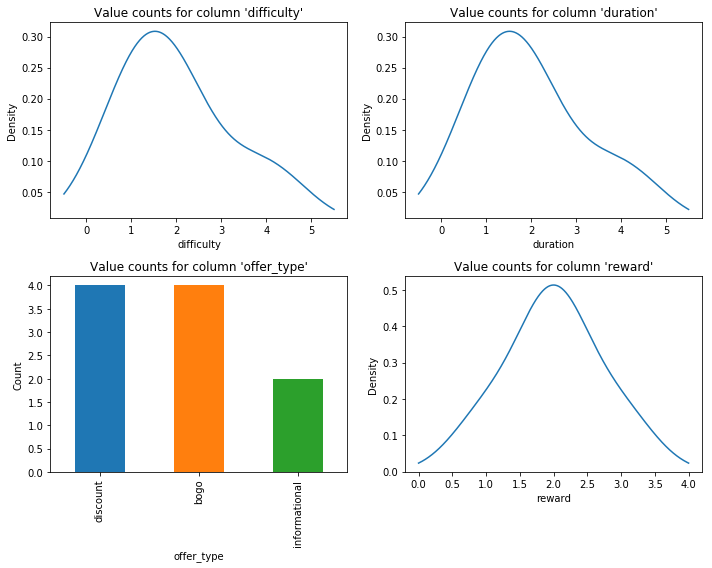

In [5]:
plot_value_distribution(df = portfolio, nrows=2, ncols=2, ignore_cols=['channels', 'id'])

In [6]:
portfolio.isna().mean()

channels      0.0
difficulty    0.0
duration      0.0
id            0.0
offer_type    0.0
reward        0.0
dtype: float64

In [7]:
# Create an instance of MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Apply one-hot encoding on the 'channels' column
encoded_channels = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_)
encoded_channels

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [8]:
# Concatenate the encoded channels with the original DataFrame
portfolio = pd.concat([portfolio, encoded_channels], axis=1)
portfolio

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [9]:
# drop the original channels column
portfolio = portfolio.drop(columns=['channels'])
portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [10]:
portfolio.rename(columns={'id': 'offer id'}, inplace = True)

## 2. Profile

In [11]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
# convert the became_memver on column to date type
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
# Calculate the number of months until the current date
current_date = pd.to_datetime('today').date()
profile['member_duration'] = (current_date.year - profile['became_member_on'].dt.year)*12 + (current_date.month - profile['became_member_on'].dt.month)
profile.head()

,age,became_member_on,gender,id,income,member_duration
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,76
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,71
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,59
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,73
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,70


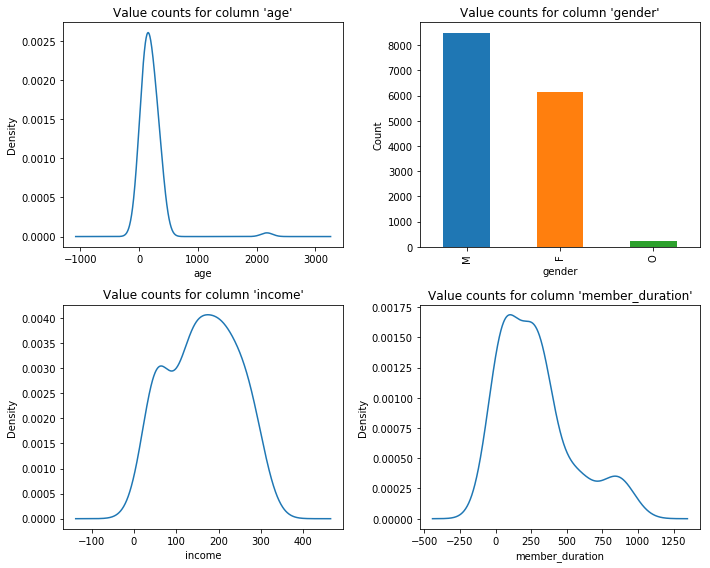

In [14]:
plot_value_distribution(df=profile, nrows = 2, ncols = 2, ignore_cols = ['became_member_on', 'id'])

Notice that we have the age with value 118 represent the missing value in age column

In [15]:
profile[profile['age'] >100].head(5)

,age,became_member_on,gender,id,income,member_duration
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,76
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,59
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,70
6,118,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,69
7,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN,68


In [16]:
# Check missing value
profile.isna().mean()

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
member_duration     0.000000
dtype: float64

In [17]:
# Fill Missing value
profile['gender'] = profile['gender'].fillna('Missing')
profile['income'] = profile['income'].fillna(-9999)

In [18]:
profile = profile.drop_duplicates()

In [19]:
profile.rename(columns={'id': 'customer id'}, inplace=True)

## 3. Transcript

In [20]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


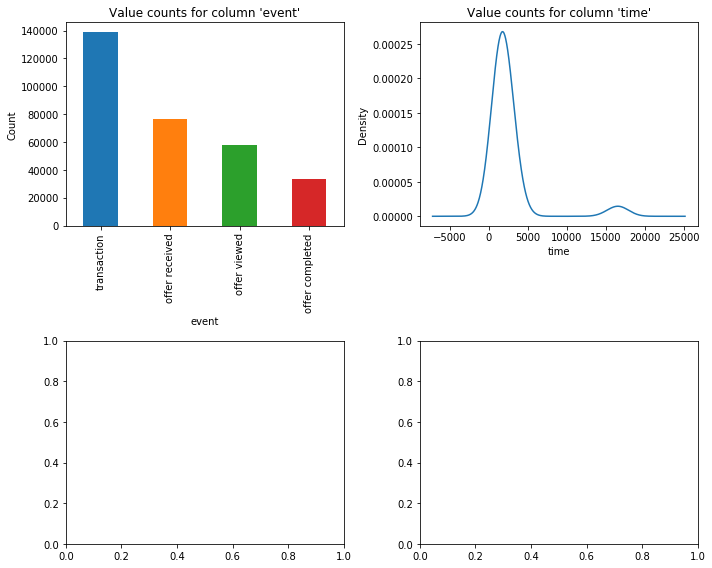

In [21]:
plot_value_distribution(df=transcript, nrows = 2, ncols = 2, ignore_cols = ['person', 'value'])

In [22]:
transcript['value'].value_counts() 

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [23]:
# Define the desired key
desired_keys = ['offer id', 'offer_id', 'amount']

for des_key in desired_keys:
    # Extract the values for the desired key or NaN if the key is not present
    transcript[des_key] = [d.get(des_key) for d in transcript['value']]

In [24]:
transcript.head()

,event,person,time,value,offer id,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,None,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,None,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,None,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,None,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,None,NaN


In [25]:
transcript['offer id'].fillna(transcript['offer_id'], inplace = True)

In [26]:
transcript.drop(columns=['value', 'offer_id'], inplace = True)

In [27]:
transcript.isna().mean()

event       0.000000
person      0.000000
time        0.000000
offer id    0.453304
amount      0.546696
dtype: float64

In [28]:
transcript['offer id'].fillna('None', inplace = True)
transcript['amount'].fillna(-1, inplace = True)

In [29]:
transcript.rename(columns={'person': 'customer id'}, inplace = True)

### 4. Merge 3 dataframe

In [30]:
print(profile['customer id'].nunique() == profile['customer id'].shape[0])
print(portfolio['offer id'].nunique() == portfolio['offer id'].shape[0])
print(transcript['customer id'].nunique() == transcript['customer id'].shape[0])

True
True
False


In [31]:
df1 = pd.merge(profile, transcript, on='customer id', how='left')
df1.head()

,age,became_member_on,gender,customer id,income,member_duration,event,time,offer id,amount
0,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer received,168,2906b810c7d4411798c6938adc9daaa5,-1.00
1,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer viewed,216,2906b810c7d4411798c6938adc9daaa5,-1.00
2,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer received,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,-1.00
3,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer viewed,348,0b1e1539f2cc45b7b9fa7c272da2e1d7,-1.00
4,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,transaction,360,None,0.35


In [32]:
master_df = pd.merge(df1, portfolio, on='offer id', how='left')
master_df.head()

,age,became_member_on,gender,customer id,income,member_duration,event,time,offer id,amount,difficulty,duration,offer_type,reward,email,mobile,social,web
0,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer received,168,2906b810c7d4411798c6938adc9daaa5,-1.00,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
1,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer viewed,216,2906b810c7d4411798c6938adc9daaa5,-1.00,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
2,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer received,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,-1.00,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
3,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer viewed,348,0b1e1539f2cc45b7b9fa7c272da2e1d7,-1.00,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
4,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,transaction,360,None,0.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
column_to_fillna = ['difficulty', 'duration', 'offer_type', 'reward', 'email', 'mobile', 'social', 'web']

for col in column_to_fillna:
    if master_df[col].dtype == 'O':
        master_df[col].fillna('None', inplace = True)
    else:
        master_df[col].fillna(-1,inplace = True)
master_df.head()

,age,became_member_on,gender,customer id,income,member_duration,event,time,offer id,amount,difficulty,duration,offer_type,reward,email,mobile,social,web
0,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer received,168,2906b810c7d4411798c6938adc9daaa5,-1.00,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
1,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer viewed,216,2906b810c7d4411798c6938adc9daaa5,-1.00,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
2,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer received,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,-1.00,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
3,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer viewed,348,0b1e1539f2cc45b7b9fa7c272da2e1d7,-1.00,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
4,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,transaction,360,None,0.35,-1.0,-1.0,None,-1.0,-1.0,-1.0,-1.0,-1.0


# IV. Data Exploratory

In [34]:
def plot_pie_chart(input_df, input_group, nrows, ncols, fig_size):
    
    groups = input_df[input_group].unique().tolist()
    
    # Create a figure and axes for the subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=fig_size)
    
    axs = axs.flatten()  # Flatten the 2D array of subplots
    
    # Plotting pie chart for events
    for i, group in enumerate(groups):
        
        temp_df = input_df[input_df[input_group] == group]
        # Compute the percentages for each event
        event_counts = temp_df['event'].value_counts(normalize=True) * 100
        
        axs[i].pie(event_counts, labels=event_counts.index, autopct='%1.1f%%')
        axs[i].set_title(f'Percentage of {group}')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

## 1. Which offer have the most demmand?

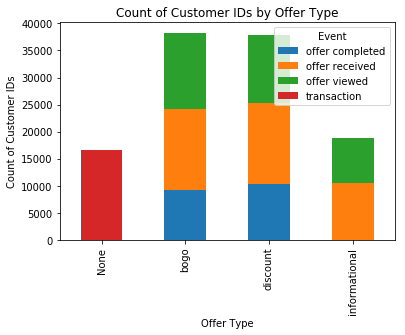

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df'
# and the columns are 'event' and 'offer_type'

# Group the data by 'offer_type' and 'event' and count the unique 'customer_id'
grouped = master_df.groupby(['offer_type', 'event'])['customer id'].nunique().reset_index()

# Pivot the dataframe to have 'offer_type' as columns, 'event' as rows, and count as values
pivot_df = grouped.pivot(index='offer_type', columns='event', values='customer id')

# Plot the bar chart
pivot_df.plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('Offer Type')
plt.ylabel('Count of Customer IDs')
plt.title('Count of Customer IDs by Offer Type')

# Add the legend
plt.legend(title='Event', loc='upper right')

# Show the chart
plt.show()

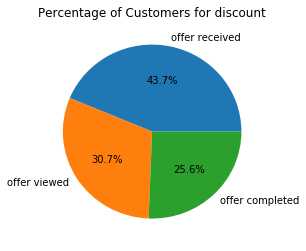

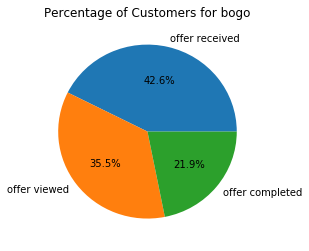

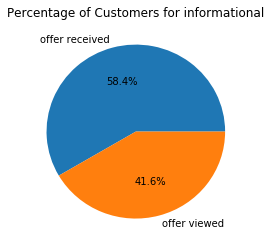

In [36]:
offer_types = master_df['offer_type'].unique().tolist()

# Plotting pie chart for events
for offer_type in offer_types:
    if offer_type == 'None':
        continue
    temp_df = master_df[master_df['offer_type'] == offer_type]
    # Compute the percentages for each event
    event_counts = temp_df['event'].value_counts(normalize=True) * 100
    
    plt.figure(figsize=(4, 4))
    plt.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%')
    plt.title(f'Percentage of Customers for {offer_type}')
    
    plt.show()

Observation:

    1. For Discount: 56.3% customer viewed the offer and 25.6% made purchase. The demand of discount is more than other offer types
    
    3. For BOGO: 57.4% customer viewd the offer but just 21.9% made purchase.
    
    2. For Informational: There is no one completing the informational offer

## 2. Which age response most in the discount/bogo group?

In [37]:
df_visualization = master_df.copy()

age_groups = [18, 24, 30, 50, float('inf')]
age_labels = ['teenager', 'young-adult', 'adult', 'elder']
df_visualization['age_group'] = pd.cut(df_visualization['age'], bins=age_groups, labels=age_labels, right=False)

# Create a new column 'income_group' based on the 'income' column
income_groups = [-9999, 30000, 50000, 80000, float('inf')]
income_labels = ['<=30k', '<=50k', '<=75k', '>75k']
df_visualization['income_group'] = pd.cut(df_visualization['income'], bins=income_groups, labels=income_labels, right=False)

df_visualization.head()

,age,became_member_on,gender,customer id,income,member_duration,event,time,offer id,amount,difficulty,duration,offer_type,reward,email,mobile,social,web,age_group,income_group
0,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer received,168,2906b810c7d4411798c6938adc9daaa5,-1.00,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,elder,<=30k
1,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer viewed,216,2906b810c7d4411798c6938adc9daaa5,-1.00,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,elder,<=30k
2,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer received,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,-1.00,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,elder,<=30k
3,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,offer viewed,348,0b1e1539f2cc45b7b9fa7c272da2e1d7,-1.00,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,elder,<=30k
4,118,2017-02-12,Missing,68be06ca386d4c31939f3a4f0e3dd783,-9999.0,76,transaction,360,None,0.35,-1.0,-1.0,None,-1.0,-1.0,-1.0,-1.0,-1.0,elder,<=30k


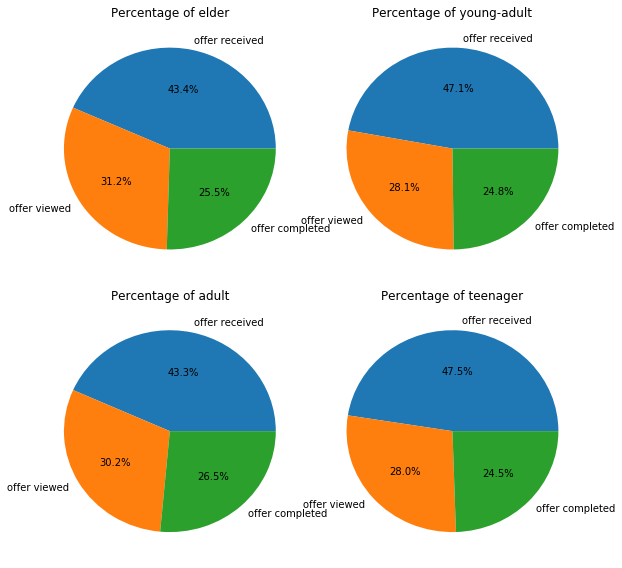

In [38]:
discount_visualization = df_visualization[df_visualization['offer_type'] == 'discount']
plot_pie_chart(discount_visualization, 'age_group', 2, 2, (8, 8))

57% of adult customers who received the discount offer either viewed or completed the offer, with 27% completing the offer. This age group exhibited the highest response rate. This suggests that a significant portion of adults not only showed interest but also followed through with the offer.

Lower response from teenage and young-adult group: In contrast to adults, the response rate from the teenage and young-adult group was lower. Only 53% of this age group responded to the offer, and out of those who did respond, only 25% completed the offer. This indicates a relatively weaker engagement compared to the adult segment.

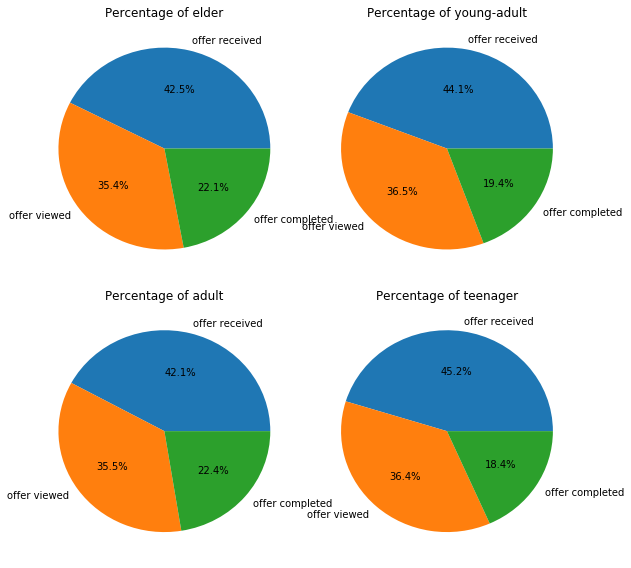

In [39]:
bogo_visualization = df_visualization[df_visualization['offer_type'] == 'bogo']
plot_pie_chart(bogo_visualization, 'age_group', 2, 2, (8, 8))

The trend observed in the response to the discount offer, where adults had a higher response rate compared to the younger group, is consistent with the response to the "buy one get one" offer as well. This suggests that the higher engagement and completion rates among adults transcend specific offer types and indicate a general preference or receptiveness among the adult customer segment.

This conclusion implies that Starbucks may have a stronger appeal to adult customers when it comes to promotional offers, whether it is a discount or a "buy one get one" deal. Understanding this preference can help Starbucks tailor their marketing strategies and target their promotions effectively to maximize customer engagement and satisfaction.

## 3. Which income response most in the discount/bogo group?

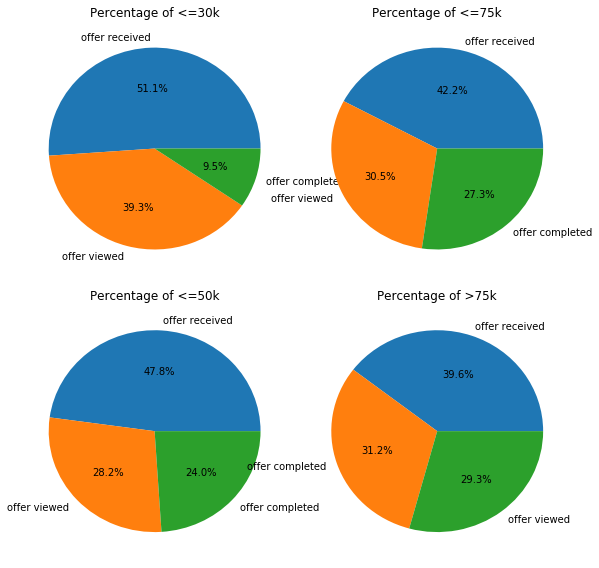

In [40]:
plot_pie_chart(discount_visualization, 'income_group', 2, 2, (8, 8))

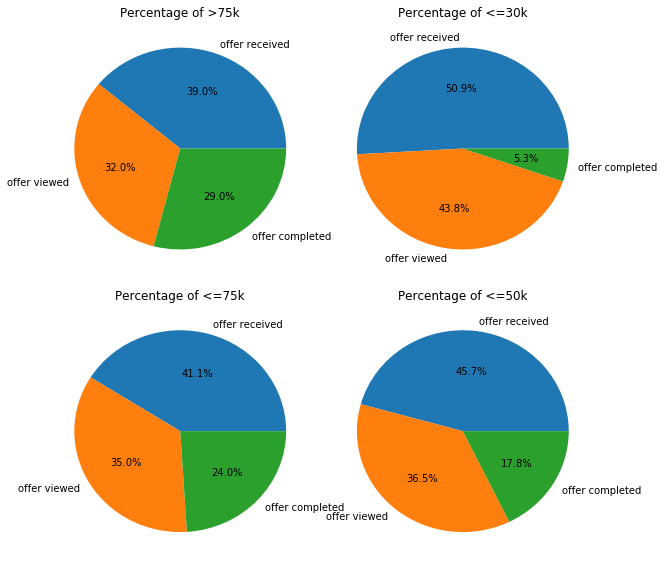

In [41]:
plot_pie_chart(bogo_visualization, 'income_group', 2, 2, (8, 8))


Missing income information (represented be group <= 30k$) correlates with lower completion rate: Customers who did not provide their income information were less likely to complete the offer, with a completion rate of only 9.5%. This suggests that the absence of income data may be indicative of reduced interest or engagement with the offer.

Higher income correlates with higher completion rate: There is a positive correlation between income level and offer completion. Customers with higher incomes were more likely to complete the offer. This implies that individuals with greater financial resources may be more inclined to take advantage of promotional offers.

These conclusions suggest that income plays a role in the completion of the offer, with higher-income individuals displaying a higher likelihood of completing the offer compared to those with missing or lower income information. Companies, including Starbucks, can use this insight to tailor their promotional strategies and target specific income brackets more effectively.

## 4. Which gender response most in the discount/bogo group?

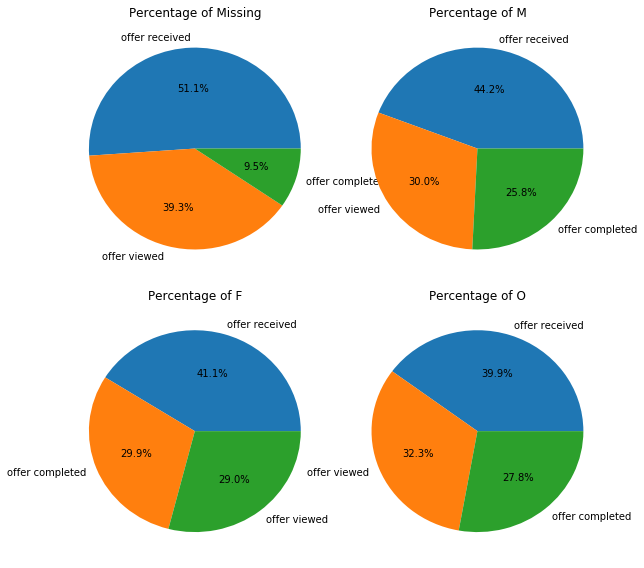

In [42]:
plot_pie_chart(discount_visualization, 'gender', 2, 2, (8, 8))

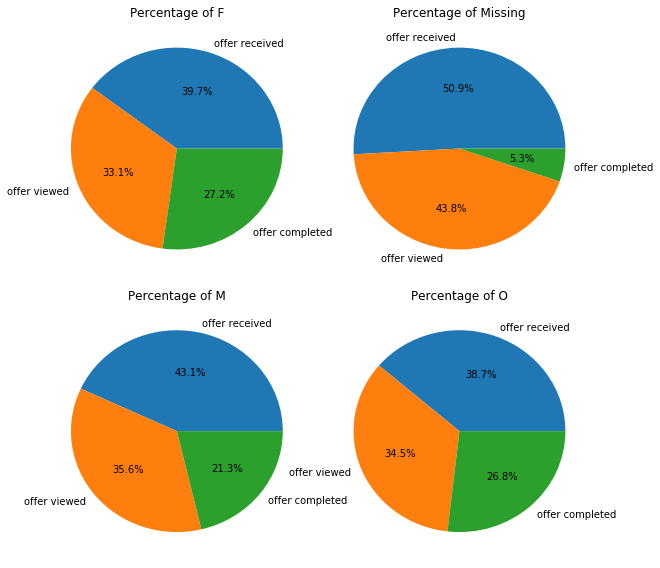

In [43]:
plot_pie_chart(bogo_visualization, 'gender', 2, 2, (8, 8))

Missing gender information correlates with lower completion rate: Customers who did not provide their gender information were less likely to complete the offer, with a completion rate of only 5%. This mising and additionaly missing income as above suggests that the absence of info data may indicate reduced interest or engagement with the offer.

Female and 'O' gender have higher response rates compared to male: Among the customers who responded to the offer, females and individuals identifying as 'O' (other) gender displayed higher response rates compared to males. This indicates that females and individuals who identify as 'O' gender are more likely to engage with the promotional offer.

These conclusions suggest that gender plays a role in the completion of the offer, with missing gender information associated with lower completion rates and females and 'O' gender individuals exhibiting higher response rates. Companies, including Starbucks, can utilize this information to refine their marketing strategies and target specific gender demographics more effectively.

## 4. Which channel response most in the discount/bogo group?

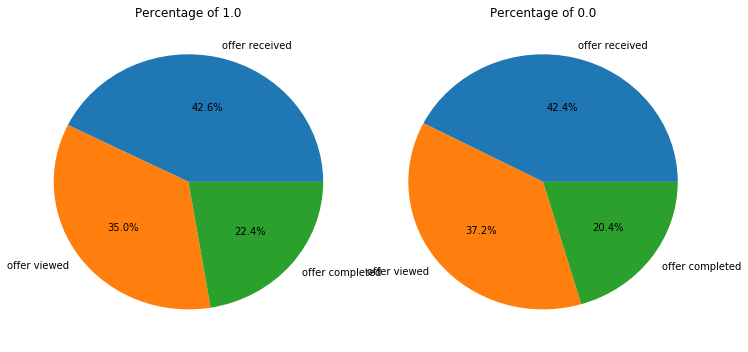

In [44]:
plot_pie_chart(bogo_visualization, 'web', 1, 2, (10, 5))

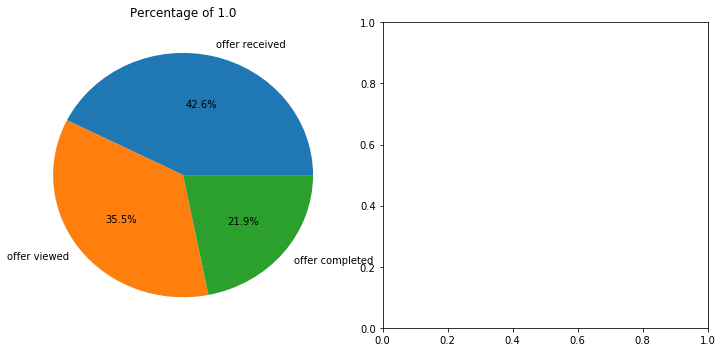

In [45]:
plot_pie_chart(bogo_visualization, 'email', 1, 2, (10, 5))

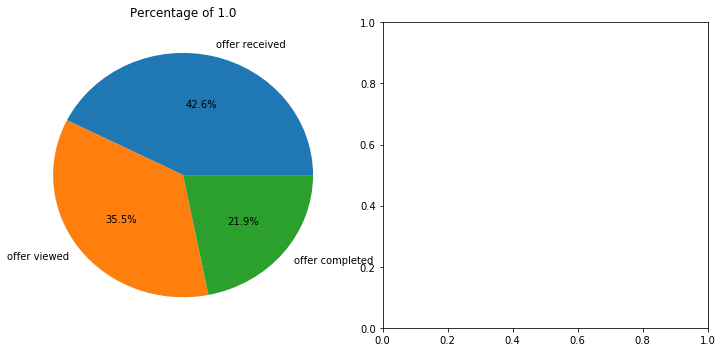

In [46]:
plot_pie_chart(bogo_visualization, 'mobile', 1, 2, (10, 5))

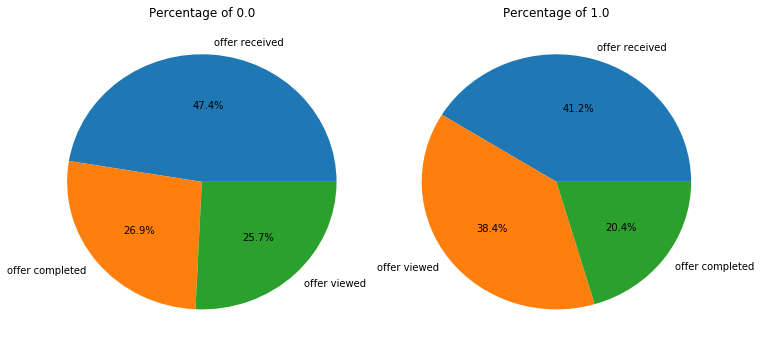

In [47]:
plot_pie_chart(bogo_visualization, 'social', 1, 2, (10, 5))

It appears that all customers will receive the "buy one get one" program via email and phone. The response rate when receiving the offer through these two channels is 58%. Similarly, when receiving the offer through web and social channels, the response rate is also around 58%. However, there is a negative signal indicating that those who receive the offer through social media have a much lower purchase rate compared to other channels.

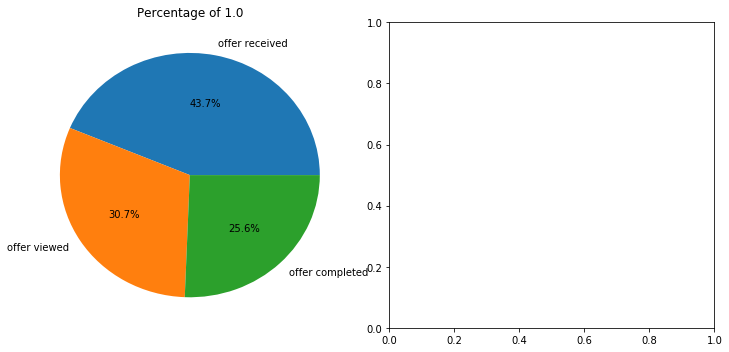

In [48]:
plot_pie_chart(discount_visualization, 'web', 1, 2, (10, 5))

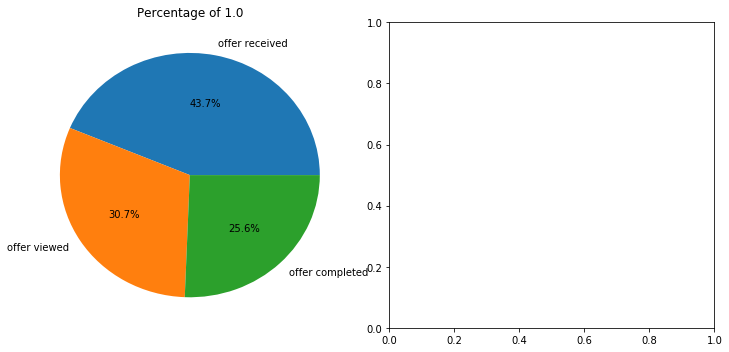

In [49]:
plot_pie_chart(discount_visualization, 'email', 1, 2, (10, 5))

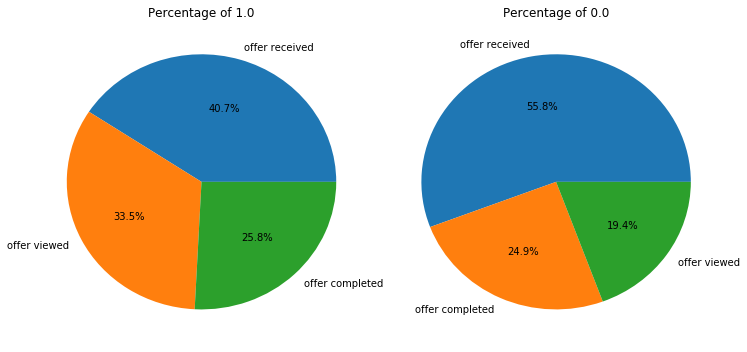

In [50]:
plot_pie_chart(discount_visualization, 'mobile', 1, 2, (10, 5))

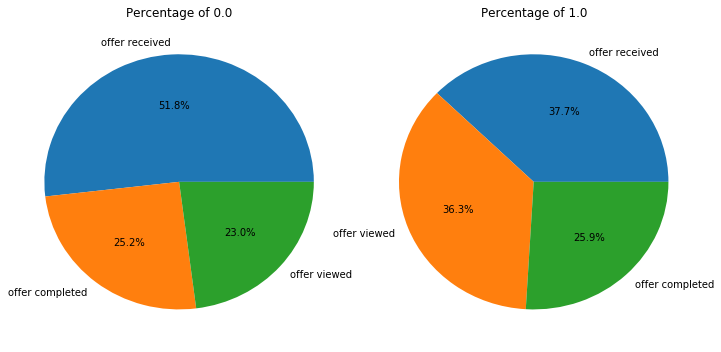

In [51]:
plot_pie_chart(discount_visualization, 'social', 1, 2, (10, 5))

For the discount program, all customers will receive the offer via email and web. The response rate when receiving the offer through these two channels is 58%. However, when the offer is received through mobile and social channels, the response rate is higher, around 60%. One notable observation is that customers who receive the discount offer via mobile have a higher completion rate compared to those who do not receive the offer through mobile.

Based on these conclusions, we can draw the following overall observations:

The "buy one get one" program does not show a significant difference in response rates between different channels. However, the purchase rate is notably lower when the offer is received through social media. This suggests that customers may be less inclined to make a purchase when the offer is received through social media platforms.

The discount program exhibits slightly higher response rates when the offer is received through mobile and social channels compared to email and web. This indicates that customers may be more receptive to the discount offer when received on mobile devices or through social media platforms.

Overall, it is important for businesses, like Starbucks, to consider the channel through which they deliver their offers and tailor their marketing strategies accordingly to maximize customer response and completion rates.

## 5. Customer Segmentation to cluster based on customer's response?

### 5.1 Pre-processing

In [52]:
df_train = master_df.drop(columns=['became_member_on', 'customer id', 'offer id'])
df_train.head()

,age,gender,income,member_duration,event,time,amount,difficulty,duration,offer_type,reward,email,mobile,social,web
0,118,Missing,-9999.0,76,offer received,168,-1.00,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
1,118,Missing,-9999.0,76,offer viewed,216,-1.00,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
2,118,Missing,-9999.0,76,offer received,336,-1.00,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
3,118,Missing,-9999.0,76,offer viewed,348,-1.00,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
4,118,Missing,-9999.0,76,transaction,360,0.35,-1.0,-1.0,None,-1.0,-1.0,-1.0,-1.0,-1.0


In [53]:
df_train['offer_type'].value_counts()

None             138953
bogo              71617
discount          69898
informational     26066
Name: offer_type, dtype: int64

In [54]:
# Create a new column 'encoded_gender'
df_train['encoded_gender'] = df_train['gender'].map({'Missing': -1, 'M': 0, 'O': 1, 'F': 1})
df_train['encoded_event'] = df_train['event'].map({'transaction': 0, 'offer received': 1, 'offer viewed': 2, 'offer completed': 3})
df_train['encoded_offer_type'] = df_train['offer_type'].map({'None': -1, 'informational': 0, 'discount': 1, 'bogo': 2})

# Print the updated DataFrame
df_train

,age,gender,income,member_duration,event,time,amount,difficulty,duration,offer_type,reward,email,mobile,social,web,encoded_gender,encoded_event,encoded_offer_type
0,118,Missing,-9999.0,76,offer received,168,-1.00,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,-1,1,1
1,118,Missing,-9999.0,76,offer viewed,216,-1.00,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,-1,2,1
2,118,Missing,-9999.0,76,offer received,336,-1.00,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,-1,1,1
3,118,Missing,-9999.0,76,offer viewed,348,-1.00,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,-1,2,1
4,118,Missing,-9999.0,76,transaction,360,0.35,-1.0,-1.0,None,-1.0,-1.0,-1.0,-1.0,-1.0,-1,0,-1
5,118,Missing,-9999.0,76,offer received,408,-1.00,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,-1,1,1
6,118,Missing,-9999.0,76,offer viewed,408,-1.00,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,-1,2,1
7,118,Missing,-9999.0,76,transaction,414,0.74,-1.0,-1.0,None,-1.0,-1.0,-1.0,-1.0,-1.0,-1,0,-1
8,118,Missing,-9999.0,76,transaction,444,1.89,-1.0,-1.0,None,-1.0,-1.0,-1.0,-1.0,-1.0,-1,0,-1
9,118,Missing,-9999.0,76,offer received,504,-1.00,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0,-1,1,1


In [55]:
df_train.drop(columns=['gender', 'event', 'offer_type'], inplace = True)
df_train.head()

,age,income,member_duration,time,amount,difficulty,duration,reward,email,mobile,social,web,encoded_gender,encoded_event,encoded_offer_type
0,118,-9999.0,76,168,-1.00,10.0,7.0,2.0,1.0,1.0,0.0,1.0,-1,1,1
1,118,-9999.0,76,216,-1.00,10.0,7.0,2.0,1.0,1.0,0.0,1.0,-1,2,1
2,118,-9999.0,76,336,-1.00,20.0,10.0,5.0,1.0,0.0,0.0,1.0,-1,1,1
3,118,-9999.0,76,348,-1.00,20.0,10.0,5.0,1.0,0.0,0.0,1.0,-1,2,1
4,118,-9999.0,76,360,0.35,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,0,-1


In [56]:
df_segmentation = df_train.drop(columns=['amount', 'duration', 'time'])

### 5.2. Univariate clustering

In [57]:
cluster = KMeans()
cluster.fit(df_segmentation[['encoded_event']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [58]:
df_segmentation['event_cluster'] = cluster.labels_

In [59]:
df_segmentation['event_cluster'].value_counts()

1    138953
7     76277
6     57725
3     33579
Name: event_cluster, dtype: int64

In [60]:
df_segmentation.groupby('event_cluster')['age', 'income', 'member_duration', 'difficulty', \
                                 'reward', 'email', 'mobile', 'social', 'web', 'encoded_gender', 'encoded_offer_type', 'encoded_event'].mean()

,age,income,member_duration,difficulty,reward,email,mobile,social,web,encoded_gender,encoded_offer_type,encoded_event
event_cluster,,,,,,,,,,,,
1,59.759725,54090.167150,79.266709,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,0.260282,-1.000000,0.0
3,57.928140,66746.005986,78.118943,9.269841,4.904137,1.0,0.898151,0.648858,0.890169,0.442032,1.466631,3.0
6,63.276778,55508.356258,75.744599,7.213235,4.426696,1.0,0.953867,0.738484,0.767813,0.237228,1.253235,2.0
7,62.524457,55711.784365,75.682814,7.707723,4.201607,1.0,0.899472,0.598909,0.799730,0.243796,1.200113,1.0


Event Group 1:

* This group represents customers who received the promotion but did not complete it.
* The average age is approximately 62.52, with an average income of around $55,712 (the least income among 3 group received offer, viewed offer and completed offer) and a member duration of approximately 75.68.
* The difficulty value is around 7.71, indicating a moderate difficulty level, and the reward value is approximately 4.20.
* Customer of this group most often received via mobile.
* The encoded_gender value suggests a slightly higher representation of males (around 0.24), and the encoded_offer_type is approximately 1.20, indicating more discount offer type.

Event Group 2:

* This group represents customers who received and viewed the promotion.
* The average age is approximately 63.28, with an average income of around $55,508 and a member duration of approximately 75.74, higher than only received group.
* The difficulty value is around 7.21, indicating a moderate difficulty level, and the reward value is approximately 4.43.
* Customer of this group most often viewed via mobile.
* The encoded_gender value suggests a slightly higher representation of males (around 0.24), and the encoded_offer_type is approximately 1.25, indicating more discount offer type.

Event Group 3:

* This group represents customers who viewed and completed the promotion.
* The average age is approximately 57.93, with an average income of around $66,746 and a member duration of approximately 78.12 (highest income and also longest duration member).
* The difficulty value is around 9.27, indicating a relatively higher difficulty level, and the reward value is approximately 4.90.
* Customer of this group most often completed via both mobile and web.
* The encoded_gender value suggests a slightly higher representation of females and "O" gender (around 0.44), and the encoded_offer_type is approximately 1.47, indicating a balanced between discount and bogo.

### Bivariate Clustering

In [61]:
cluster2 = KMeans()
cluster2.fit(df_segmentation[['encoded_event', 'encoded_offer_type']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [62]:
df_segmentation['event_offer_cluster'] = cluster2.labels_

In [63]:
df_segmentation['event_offer_cluster'].value_counts()

1    138953
5     30543
4     30499
0     26066
3     25449
2     21445
6     17910
7     15669
Name: event_offer_cluster, dtype: int64

In [64]:
df_segmentation.groupby('event_offer_cluster')['age', 'income', 'member_duration', 'difficulty', \
                                 'reward', 'email', 'mobile', 'social', 'web', 'encoded_gender', 'encoded_offer_type', 'encoded_event'].mean()

,age,income,member_duration,difficulty,reward,email,mobile,social,web,encoded_gender,encoded_offer_type,encoded_event
event_offer_cluster,,,,,,,,,,,,
0,62.880687,55591.552444,75.804420,0.000000,0.000000,1.0,1.000000,0.548799,0.451201,0.245454,0.0,1.415522
1,59.759725,54090.167150,79.266709,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,0.260282,-1.0,0.000000
2,63.732945,55835.811798,75.646724,10.215388,2.714665,1.0,0.875822,0.683796,1.000000,0.235300,1.0,2.000000
3,62.903336,55321.128925,75.764706,7.753350,7.753350,1.0,1.000000,0.836104,0.736100,0.237652,2.0,2.000000
4,62.603331,55626.609463,75.715007,7.500246,7.500246,1.0,1.000000,0.748287,0.748910,0.241549,2.0,1.000000
5,62.399339,55753.392889,75.620764,11.759552,3.003503,1.0,0.748944,0.499067,1.000000,0.243296,1.0,1.000000
6,58.123562,65545.769068,78.410776,11.045896,2.860748,1.0,0.809045,0.584757,1.000000,0.419207,1.0,3.000000
7,57.704767,68117.902291,77.785372,7.239773,7.239773,1.0,1.000000,0.722126,0.764631,0.468122,2.0,3.000000


The completed event group can be divided into two subgroups: the discount group and the BOGO group.

Regarding the discount group:

* The average age is 57, which is lower compared to other groups. They are predominantly of the "other" gender or female.
* They have higher income and longer member duration, indicating better financial resources and stronger engagement with the company.
* The discount group tends to spend more money per product, showing a higher willingness to make purchases.
* They are more responsive when receiving offers through mobile channels.

As for the BOGO group:

* They have similarities with the discount group but higher income.
* The BOGO group shows the highest response rate when offers are received through web channels.

In conclusion, the discount group, despite being slightly younger, demonstrates a strong response to offers, particularly through mobile channels. The BOGO group, on the other hand, has higher income and is most responsive when offers are received via web channels. These insights suggest that tailoring marketing strategies based on age, gender, income, and preferred channels can optimize the response rates of different customer segments.

# V. Modeling

## 1. Pre-processing

In [65]:
# remove the customer who have not received any offer
df_train = df_train[df_train['encoded_event'] != 0]
# As we want to predict who will response to the offer, the group received offer but not doing anything is 0 and the group viewed
# and completed offer is 1
df_train['target'] = df_train['encoded_event'].map({1: 0, 2: 1, 3: 1})
df_train.head(9)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,age,income,member_duration,time,amount,difficulty,duration,reward,email,mobile,social,web,encoded_gender,encoded_event,encoded_offer_type,target
0,118,-9999.0,76,168,-1.0,10.0,7.0,2.0,1.0,1.0,0.0,1.0,-1,1,1,0
1,118,-9999.0,76,216,-1.0,10.0,7.0,2.0,1.0,1.0,0.0,1.0,-1,2,1,1
2,118,-9999.0,76,336,-1.0,20.0,10.0,5.0,1.0,0.0,0.0,1.0,-1,1,1,0
3,118,-9999.0,76,348,-1.0,20.0,10.0,5.0,1.0,0.0,0.0,1.0,-1,2,1,1
5,118,-9999.0,76,408,-1.0,10.0,10.0,2.0,1.0,1.0,1.0,1.0,-1,1,1,0
6,118,-9999.0,76,408,-1.0,10.0,10.0,2.0,1.0,1.0,1.0,1.0,-1,2,1,1
9,118,-9999.0,76,504,-1.0,7.0,7.0,3.0,1.0,1.0,1.0,1.0,-1,1,1,0
10,118,-9999.0,76,504,-1.0,7.0,7.0,3.0,1.0,1.0,1.0,1.0,-1,2,1,1
14,118,-9999.0,76,552,-1.0,10.0,10.0,2.0,1.0,1.0,1.0,1.0,-1,3,1,1


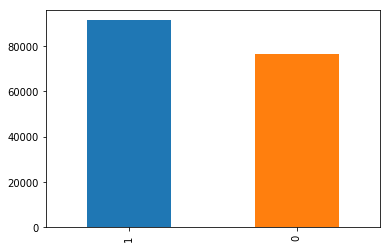

In [66]:
# Plot to check the balance status of two class in the target
df_train['target'].value_counts().plot.bar()

The two class are pretty banlanced!

## 2. Train Test Spliting

In [67]:
# Split the data into features and target label
X = df_train[['age', 'income', 'member_duration', 'time', 'amount', 'difficulty', 'duration', 'reward', 'email', \
              'mobile', 'social', 'web', 'encoded_gender', 'encoded_offer_type']]
y = df_train['target']

In [68]:
# Split training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [69]:
def print_results(results):
  print('Best params: {}\n'.format(results.best_params_))
  means = results.cv_results_['mean_test_score']
  stds = results.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds,results.cv_results_['params']):
    print('{} (+/-{}) for {}'.format(round(mean,5),round(std*2,5),params))

## 3. Building ML Model

### 3.1. Using Logistic Regression

In [70]:
LR_model = LogisticRegression()
parameters = {
    'C':[0.01, 0.1, 1, 10, 100]
}
cv = GridSearchCV(LR_model, parameters, cv=5, scoring = 'precision')
cv.fit(X_train, y_train)
print_results(cv)

joblib.dump(cv.best_estimator_, "LR_model.pkl")

Best params: {'C': 1}

0.56371 (+/-0.00109) for {'C': 0.01}
0.56395 (+/-0.00185) for {'C': 0.1}
0.5641 (+/-0.00196) for {'C': 1}
0.56365 (+/-0.00108) for {'C': 10}
0.56376 (+/-0.00111) for {'C': 100}


['LR_model.pkl']

### 3.2. Using Random Forest

In [71]:
RF_model = RandomForestClassifier()
parameters = {
    'n_estimators': [10, 50]
}
cv = GridSearchCV(RF_model, parameters, cv=5, scoring = 'precision')
cv.fit(X_train, y_train)
print_results(cv)

joblib.dump(cv.best_estimator_, "RF_model.pkl")

Best params: {'n_estimators': 50}

0.74187 (+/-0.02022) for {'n_estimators': 10}
0.74926 (+/-0.01016) for {'n_estimators': 50}


['RF_model.pkl']

### 3.4. Comparision and Finding Best Model

In [72]:
models = {}
for mdl in ['LR', 'RF']:
  models[mdl] = joblib.load('{}_model.pkl'.format(mdl))

In [73]:
def evaluate_model(name, model, feature, labels):
  start =  time()
  y_pred = model.predict(feature)
  end = time()
  score = round(f1_score(y_test, y_pred, average ='weighted'), 4)
  cfm = confusion_matrix(y_test, y_pred)
  recall = round(recall_score(y_test, y_pred, pos_label=1, average='binary'), 4)
  precision = round(precision_score(y_test, y_pred, average='weighted'), 4)
  print('{} -- F1-score: {} /\n recall-score: {} /\n precision-score: {} /\n Latency: {} ms /\n CFM: {}'.format(name, score, recall, precision, round(end - start), cfm))

In [74]:
for name, mdl in models.items():
  evaluate_model(name, mdl, X_test, y_test)

LR -- F1-score: 0.5129 /
 recall-score: 0.8348 /
 precision-score: 0.552 /
 Latency: 0 ms /
 CFM: [[ 3506 11773]
 [ 3013 15225]]
RF -- F1-score: 0.7071 /
 recall-score: 0.7354 /
 precision-score: 0.707 /
 Latency: 1 ms /
 CFM: [[10292  4987]
 [ 4826 13412]]
